In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

from shapely.geometry import Point
from shapely.prepared import prep

In [3]:
nc_path = "MAIAC_AOD_2024.nc"
ds = xr.open_dataset(nc_path)

print(ds)

<xarray.Dataset> Size: 278kB
Dimensions:  (lat: 230, lon: 300)
Coordinates:
  * lat      (lat) float32 920B 25.0 25.05 25.1 25.15 ... 36.3 36.35 36.4 36.45
  * lon      (lon) float32 1kB -108.0 -107.9 -107.9 ... -93.15 -93.1 -93.05
Data variables:
    AOD      (lat, lon) float32 276kB ...
Attributes:
    title:    Annual mean AOD (lat ascending) for 2024
    history:  Reordered lat to ascending and flipped AOD accordingly
    source:   post-process script


In [4]:
# Cell 4: Pick AOD variable robustly + handle time dimension if present

# Try common AOD variable names; fallback to "AOD"
candidate_vars = ["AOD", "aod", "AOD_550", "AOD550", "Optical_Depth_055", "Aerosol_Optical_Depth"]
aod_var = None
for v in candidate_vars:
    if v in ds.data_vars:
        aod_var = v
        break
if aod_var is None:
    # fallback: find any var containing 'aod'
    for v in ds.data_vars:
        if "aod" in v.lower():
            aod_var = v
            break

if aod_var is None:
    raise ValueError("Could not find an AOD variable. Check ds.data_vars and update the variable name.")

print("Using AOD variable:", aod_var)

# Lat/Lon
lat_name = "lat" if "lat" in ds.coords else ("latitude" if "latitude" in ds.coords else None)
lon_name = "lon" if "lon" in ds.coords else ("longitude" if "longitude" in ds.coords else None)

if lat_name is None or lon_name is None:
    raise ValueError("Could not find lat/lon coords. Check ds.coords and update lat_name/lon_name.")

aod = ds[aod_var]

# If time exists, average (or you can choose median)
if "time" in aod.dims:
    aod = aod.mean("time", skipna=True)

lat = ds[lat_name].values
lon = ds[lon_name].values

print("AOD dims:", aod.dims, "shape:", aod.shape)
print("Lat range:", float(np.nanmin(lat)), "to", float(np.nanmax(lat)))
print("Lon range:", float(np.nanmin(lon)), "to", float(np.nanmax(lon)))


Using AOD variable: AOD
AOD dims: ('lat', 'lon') shape: (230, 300)
Lat range: 25.0 to 36.45000076293945
Lon range: -108.0 to -93.05007934570312


In [5]:
# Cell 5: Get the exact Texas boundary polygon (Natural Earth: Admin-1 states/provinces)

shpfilename = shapereader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)

records = shapereader.Reader(shpfilename).records()

texas_geom = None
for r in records:
    attrs = r.attributes
    # US state filter
    if attrs.get("admin") == "United States of America" and attrs.get("name") == "Texas":
        texas_geom = r.geometry
        break

if texas_geom is None:
    raise RuntimeError("Texas boundary not found in Natural Earth admin_1_states_provinces.")

texas_prepared = prep(texas_geom)
print("Texas polygon loaded.")


Texas polygon loaded.


In [6]:
# Cell 6: Subset to Texas bounding box FIRST for speed (then clip precisely with polygon mask)

# Texas bbox (approx)
lat_min, lat_max = 25.0, 36.7
lon_min, lon_max = -106.8, -93.3

aod_box = aod.sel({lat_name: slice(lat_min, lat_max), lon_name: slice(lon_min, lon_max)})
lat_box = aod_box[lat_name].values
lon_box = aod_box[lon_name].values

# Build 2D lon/lat grid for masking
LON, LAT = np.meshgrid(lon_box, lat_box)

# Mask points outside Texas polygon
mask = np.zeros(LON.shape, dtype=bool)

# Vectorized-ish loop (still fine for typical grids). If grid is huge, we can optimize further.
for i in range(LON.shape[0]):
    for j in range(LON.shape[1]):
        mask[i, j] = texas_prepared.contains(Point(float(LON[i, j]), float(LAT[i, j])))

aod_tx = np.where(mask, aod_box.values, np.nan)

print("Clipped AOD stats (Texas only):")
print("min:", float(np.nanmin(aod_tx)), "max:", float(np.nanmax(aod_tx)), "mean:", float(np.nanmean(aod_tx)))


Clipped AOD stats (Texas only):
min: 0.08044355362653732 max: 0.2721879184246063 mean: 0.129909485578537


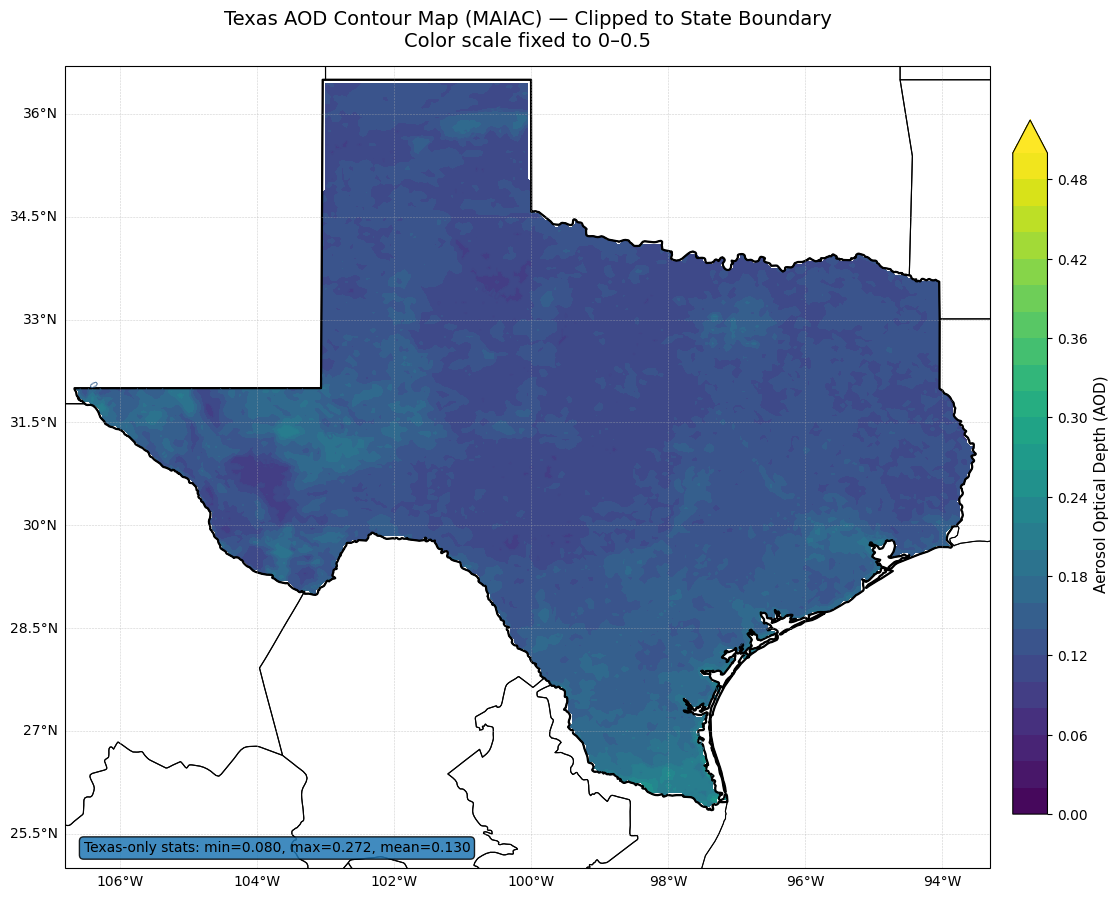

Saved: Texas_AOD_Contour_Clipped_0_0.5.png


In [7]:
# Cell 7: Plot a high-quality Texas-clipped contour map (fixed scale 0–0.5) + save output

# Contour levels for precision
levels = np.linspace(0, 0.5, 26)  # more levels = smoother interpretation

fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Map extent around Texas
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add clean basemap features
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=0.8)

# Draw Texas outline thicker
ax.add_geometries([texas_geom], crs=ccrs.PlateCarree(),
                  facecolor="none", edgecolor="black", linewidth=1.6)

# Plot filled contours (fixed range 0–0.5)
cf = ax.contourf(LON, LAT, aod_tx, levels=levels, vmin=0, vmax=0.5, extend="max",
                 transform=ccrs.PlateCarree())

# Optional: add contour lines for clarity (standout)
cl = ax.contour(LON, LAT, aod_tx, levels=np.linspace(0, 0.5, 11),
                linewidths=0.4, transform=ccrs.PlateCarree())
ax.clabel(cl, inline=True, fontsize=7, fmt="%.2f")

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.4, alpha=0.6, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# Colorbar
cbar = plt.colorbar(cf, ax=ax, pad=0.02, shrink=0.85)
cbar.set_label("Aerosol Optical Depth (AOD)", fontsize=11)

# Title + stats annotation (professional touch)
aod_min = float(np.nanmin(aod_tx))
aod_max = float(np.nanmax(aod_tx))
aod_mean = float(np.nanmean(aod_tx))

ax.set_title("Texas AOD Contour Map (MAIAC) — Clipped to State Boundary\nColor scale fixed to 0–0.5",
             fontsize=14, pad=14)

ax.text(0.02, 0.02,
        f"Texas-only stats: min={aod_min:.3f}, max={aod_max:.3f}, mean={aod_mean:.3f}",
        transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle="round", alpha=0.85))

plt.tight_layout()

out_path = "Texas_AOD_Contour_Clipped_0_0.5.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)
